In [276]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf
from scipy.misc import imread
import matplotlib.pyplot as plt
import shutil

In [2]:
seed=128
rng=np.random.RandomState(seed)

In [5]:
train=pd.read_csv('/home/kantareddy/Downloads/Identify Digits/Train_UQcUa52/train.csv')
test=pd.read_csv('/home/kantareddy/Downloads/Identify Digits/Test_fCbTej3.csv')
submission=pd.read_csv('/home/kantareddy/Downloads/Sample_Submission_lxuyBuB.csv')

In [6]:
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


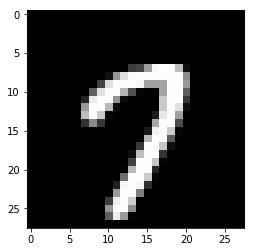

In [24]:
img_name=rng.choice(train.filename)
filepath=os.path.join(r'/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train',img_name)
img=imread(filepath,flatten=True)
plt.imshow(img,cmap='gray')
plt.show()

In [161]:
temp=[]
for img_name in train.filename:
    img_path=os.path.join('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train',img_name)
    img=imread(img_path,flatten=True)
    img=img.astype('float32')
    temp.append(img)
train_x=np.stack(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [162]:
train_x.shape

(49000, 28, 28)

In [163]:
temp=[]
for img_name in test.filename:
    img_path=os.path.join('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/test',img_name)
    img=imread(img_path,flatten=True)
    img=img.astype('float32')
    temp.append(img)
test_x=np.stack(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [164]:
split_size = int(train_x.shape[0]*0.7)
train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [165]:
train_x.shape

(34300, 28, 28)

In [193]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).loc[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

In [194]:
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01

### define weights and biases of the neural network (refer this article if you don't understand the terminologies)

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [195]:
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [196]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y))

In [197]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [198]:
init = tf.global_variables_initializer()

In [199]:
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print("Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost))
    
    print("\nTraining complete!")
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print("Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)}))
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch: 1 cost = 8.57081
Epoch: 2 cost = 1.69188
Epoch: 3 cost = 0.95774
Epoch: 4 cost = 0.59081
Epoch: 5 cost = 0.45858

Training complete!
Validation Accuracy: 0.9587755


Prediction is:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


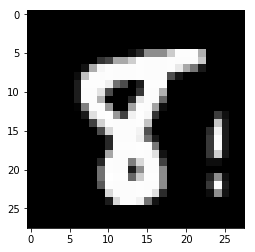

In [200]:
img_name = rng.choice(test.filename)
filepath = os.path.join('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print("Prediction is: ", pred[test_index])

plt.imshow(img, cmap='gray')
plt.show()

In [264]:
for i in train[train['label']==1]['filename']:
    if os.path.exists('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/'+str(1)):
        pass
    else:
        os.mkdir('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/'+str(1))
        copy('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/'+str(i),'/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/'+str(1)+'/')

In [269]:
for i in train[train['label']==1]['filename']:
    copy('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/'+str(i),'/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/'+str(1)+'/')

IsADirectoryError: [Errno 21] Is a directory: '/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/1/'

In [294]:
for i in train[train['label']==3]['filename']:
    shutil.move('/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/'+str(i),'/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/3')

FileNotFoundError: [Errno 2] No such file or directory: '/home/kantareddy/Downloads/Identify_Digits/Train_UQcUa52/Images/train/4.png'